This demo will show how to programmatically access the Google Earth Engine API to obtain a time series of satellite images for a given time window and region. 

Prerequisites:
- Google Earth Engine Python API package: ee
- Third party Earth Engine wrapper package: geemap
- GeoTIFF read, transform, and write package: rasterio


In [1]:
import ee 
import geemap
from datetime import datetime
import numpy as np
import rasterio #for reading images
import matplotlib.pyplot as plt 
import pandas as pd

In [2]:
 def cloudscore(image):
        '''
        Inner function for computing cloud score such that we can remove 
        bad images from the landsat collections we download.
        Implementation in javascript can be found of Google Earth Engine 
        website under (landsat algorithms), translation to python by KH.
        Further help from Nicholas Clinton at 
        https://urldefense.com/v3/__https://gis.stackexchange.com/questions/252685/filter-landsat-images-base-on-cloud-cover-over-a-region-of-interest*5Cn__;JQ!!LLK065n_VXAQ!zP9K-68-_oPkaNWFZdbTYYnai85ggL4j3FhdqssLkim-RneBr2NqD6Ka4fu6yw-v$         '''
        cloud = ee.Algorithms.Landsat.simpleCloudScore(image).select('cloud')
        cloudiness = cloud.reduceRegion(ee.Reducer.mean(),
                                        geometry=region,
                                        scale=30)
        image = image.set(cloudiness)
        return image

In [3]:
# Trigger the authentication flow
ee.Authenticate()

# Initialize the library
ee.Initialize()

Enter verification code: 4/1AX4XfWgMvT0PmaVvJTJlZwjUl9dCuPF-bK1TBxk_UobDX_527jpeXuBCjuo

Successfully saved authorization token.


This is where we define the lat-long bounding box that defines the region for our satellite images. Notice how that bounding box starts and ends in the same place

In [4]:

# bbox = [(-118.5218120749397,36.99786234125541),
#     (-118.51807843999097,36.99786234125541),
#     (-118.51807843999097,37.00010729974639),
#     (-118.5218120749397,37.00010729974639),
#     (-118.5218120749397,36.99786234125541)]

# = [(7.0089096, 45.978629149999996),
#  (7.0466264, 45.978629149999996),
#  (7.0466264, 46.02018385),
#  (7.0089096, 46.02018385),
#  (7.0089096, 45.978629149999996)]

# format:
#     bbox = [(),
#     (-118.51270890110236,37.006279860016086),
#     (-118.5332653509925,37.006279860016086),
#     (-118.5332653509925,36.99695760726187)]

#this one was my dataset

#  bbox = [(-118.51270890110236,36.99695760726187),
#     (-118.51270890110236,37.006279860016086),
#     (-118.5332653509925,37.006279860016086),
#     (-118.5332653509925,36.99695760726187)]

bbox =[(79.8096398872554,42.295437794411406),
(79.8096398872554,42.169352359125746),
(80.24634643022415,42.169352359125746),
(80.24634643022415,42.295437794411406)]

Here we obtain an EE image collection for LANDSAT 8 from a specified date range and region

In [5]:
#old dates
# start_date = datetime(2020,1,1)
# end_date = datetime(2021,10,1)
start_date = datetime(1999,1,1)
#test with 97 return to 99
end_date = datetime(2003,1,1)

region = ee.Geometry.Polygon(bbox)

# col = ee.ImageCollection('LANDSAT/LT05/C01/T1_TOA')# Landsat 5
# col = ee.ImageCollection('LANDSAT/LE07/C01/T1_TOA') # Landsat 7 - has defects
# collection = ee.ImageCollection('LANDSAT/LC08/C01/T1_TOA').filterDate(start_date,end_date).filterBounds(region)
collection = ee.ImageCollection('LANDSAT/LE07/C01/T1_TOA').filterDate(start_date,end_date).filterBounds(region)

Here we filter out cloudy images. The lower the cloud_tol, the less cloud tolerance

In [6]:
cloud_tol=15
collection = collection.map(algorithm=cloudscore).filter(ee.Filter.lt('cloud', cloud_tol))
type(collection)
# average_land7 = collection.map(algorithm=cloudscore).filter(ee.Filter.lt('cloud', cloud_tol))

ee.imagecollection.ImageCollection

In [7]:
filtered = collection
for i in dates[6:]:
    filtered = filtered.filter(ee.Filter.date(i, i).Not())


NameError: name 'dates' is not defined

In [8]:
collection = filtered

In [165]:
collection = collection.select(['B1','B2','B3', 'B4', 'B5', 'B6_VCID_1', 'B6_VCID_2', 'B7', 'B8'])


In [166]:
# # collection[:6]
# image_names

### average this bitch ass collection with the 6 compatible images using no bands

In [187]:
avg_img_lan7 = collection.mean()
type(avg_img_lan7 )

ee.image.Image

To see a full list of Landsat 8 bands visit: https://urldefense.com/v3/__https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T2_SR__;!!LLK065n_VXAQ!zP9K-68-_oPkaNWFZdbTYYnai85ggL4j3FhdqssLkim-RneBr2NqD6Ka4QdkmbFN$ . Here we select: B2-blue; B3-green; B4-red; B5-near infrared; B6-shortwave infrared 1; B7-shortwave infrared 2; 

In [188]:
# collection = collection.select(['B5'])
# avg_img_lan7 = collection.select(['B1','B2','B3', 'B4', 'B5', 'B6_VCID_1', 'B6_VCID_2', 'B7', 'B8'])
# collection = collection.select([])

In [189]:
avg_img_lan7

In [190]:
# img

In [191]:
# # Load a 5-year Landsat 7 composite 1999-2003.
average_land7 = ee.Image('LANDSAT/LE7_TOA_5YEAR/1999_2003')
# average_land7 = ee.ImageCollection('LANDSAT/LE07/C01/T1_TOA').filterDate(start_date,end_date).filterBounds(region)# # Compute NDVI.
# # 'Engilchek_Glacier_2001-10-02.tif'
# NDSI_avg_test = (average_land7.select('B2').subtract(average_land7.select('B5'))
#              .divide(average_land7.select('B5').add(average_land7.select('B5'))))
NDSI_avg = (avg_img_lan7.select('B2').subtract(avg_img_lan7.select('B5'))
             .divide(avg_img_lan7.select('B5').add(avg_img_lan7.select('B5'))))

# with rasterio.open(NDSI_avg) as src:
#     first_band = src.read(1)
#     NDSI_avg_img = src.read()
# rolled_img = np.rollaxis(NDSI_avg_img, 0,3)
# print(rolled_img.shape)
# plt.imshow(rolled_img[:,:,0:3])

#ignore after
NDSI_avg = (avg_img_lan7.select('B2').subtract(avg_img_lan7.select('B5'))
             .divide(avg_img_lan7.select('B5').add(avg_img_lan7.select('B5'))))
NDSI_avg.getInfo()

{'type': 'Image',
 'bands': [{'id': 'B2',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'crs': 'EPSG:4326',
   'crs_transform': [1, 0, 0, 0, 1, 0]}]}

In [174]:
# band_names = avg_img_lan7.bandNames()
# print('Band names:', band_names.getInfo())  # 

In [192]:
#     image = ee.Image(collection_list.get(i))
geemap.ee_export_image(NDSI_avg, filename = "Engilchek_glacier_{PERFECTION}.tif", scale = 100, region = region, file_per_band = False)

Generating URL ...
Data downloaded to C:\Users\Administrator\ee folder\Engilchek_glacier_{PERFECTION}.tif


In [194]:
with rasterio.open('Engilchek_glacier_{PERFECTION}.tif') as src:
    first_band = src.read(1)
    img = src.read()

(142, 487, 1)


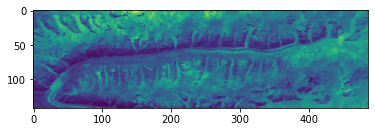

In [195]:
rolled_img = np.rollaxis(img, 0,3)
print(rolled_img.shape)
plt.imshow(rolled_img[:,:,0:3])

In [94]:
# collection = collection.select(['B2','B3', 'B5', 'B6', 'B7'])
# #["B1","B2","B3"]

In [95]:
# collection_list = collection_2.toList(collection_2.size())
# # type(collection_list)
# collection_size = collection_list.size().getInfo()
# dates = geemap.image_dates(collection_2, date_format='YYYY-MM-dd').getInfo()

In [106]:
collection_list = collection.toList(collection.size())
# type(collection_list)
collection_size = collection_list.size().getInfo()
dates = geemap.image_dates(collection, date_format='YYYY-MM-dd').getInfo()

Next, we will write the images from the image collection to our local machine as a geotiff

In [107]:
list_a = []
for i, date in enumerate(dates):
    image = ee.Image(collection_list.get(i))
    geemap.ee_export_image(image, filename = "Engilchek_glacier_{}.tif".format(date), scale = 100, region = region, file_per_band = False)
#     list_a.append(filename)

Generating URL ...
An error occurred while downloading.
Expression evaluates to an image with no bands.
Generating URL ...
An error occurred while downloading.
Expression evaluates to an image with no bands.
Generating URL ...
An error occurred while downloading.
Expression evaluates to an image with no bands.
Generating URL ...
An error occurred while downloading.
Expression evaluates to an image with no bands.
Generating URL ...
An error occurred while downloading.
Expression evaluates to an image with no bands.
Generating URL ...
An error occurred while downloading.
Expression evaluates to an image with no bands.
Generating URL ...
An error occurred while downloading.
Expression evaluates to an image with no bands.
Generating URL ...
An error occurred while downloading.
Expression evaluates to an image with no bands.
Generating URL ...
An error occurred while downloading.
Expression evaluates to an image with no bands.
Generating URL ...
An error occurred while downloading.
Expressi

We will to use rasterio to read the geotiff from our local machine

In [108]:
# "LANDSAT7_{}.tif".format(date)
image_names = []
for i, date in enumerate(dates):
    image_names.append("Engilchek_Glacier_{}.tif".format(date))

In [109]:
# image_names

In [110]:
with rasterio.open('Engilchek_glacier_2002-10-05.tif') as src:
    first_band = src.read(1)
    img = src.read()
# print(img.shape)
#LANDSAT8_2020-01-25.tif
#LANDSAT7_1999-08-17.tif

RasterioIOError: Engilchek_glacier_2002-10-05.tif: No such file or directory

Finally, we can view our image with matplotlib's pyplot

(145, 363, 10)


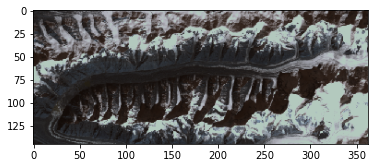

In [100]:
rolled_img = np.rollaxis(img, 0,3)
print(rolled_img.shape)
plt.imshow(rolled_img[:,:,0:3])

In [101]:
s_imgs = []
for i in range(len(dates)):
    with rasterio.open('Engilchek_Glacier_2001-10-02.tif') as src:
        first_band = src.read(1)
        img = src.read()
        s_imgs.append(img)
s_imgs = np.array(s_imgs)
# print(img.shape)
#LANDSAT8_2020-01-25.tif
#LANDSAT7_1999-08-17.tif

numpy.ndarray

In [46]:
# band 1,2,3 clips the data, and 5 as well it seems

In [47]:
### Do some research and apply different bands

In [48]:
### Perhaps it would be better to expand this image even more to see features.

In [49]:
### segementationa dn creating a time series.

In [50]:
### Make some form of analyses on the features, maybe used feature classification.

In [51]:
# TO DO:

# A SINGLE DATAFRAME: GLACIER IMAGE, GEOGRAPHICAL REGION, DATES, META DATA, IMAGE ITSELF, LABEL
# EMPTY NUMPY ARRAY, NONES, 

# META DATA, RAW IMAGE, DATES, SAME DIMENSIONS AS RAW IMAGE. 

In [20]:
import pandas as pd

In [21]:
s_imgs_empty = s_imgs.copy()
s_imgs_empty.fill(None)
# s_imgs_empty = pd.Series(s_imgs_empty)

In [22]:
s_imgs_empty

array([[[[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         ...,
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan]],

        ...,

        [[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [nan, nan

In [ ]:
image = np.array(s_imgs[:6]).mean(axis=(0,1))
# print(avg_img.shape)

image.shape
var axes = { image:0, band:1 }
var sort = array.arraySlice(axes.band, 0, 1); 

In [24]:
# for i in range(len(dates)):
#     with rasterio.open('Engilchek_Glacier_2001-10-02.tif') as src:
#         first_band = src.read(1)
# img = src.read()

# rolled_img = np.rollaxis(avg_img, 0,3)
# print(rolled_img.shape)
# plt.imshow(rolled_img[:,:,0:3])

AxisError: 'start' arg requires -2 <= start < 3, but 3 was passed in

In [112]:
#Series version
# list_a = []
s_pixels = pd.Series(list(s_imgs), name = 'image_data')
s_pixels_empty = pd.Series(list(s_imgs_empty), name = 'image_empty')
s_dates = pd.Series(dates, name = 'dates')
# list(img.shape) # for one instance
s_bbox = pd.Series([bbox]*len(dates), name = 'bbox')
s_image_names = pd.Series(image_names, name = 'image _names')

# s_pixels

In [114]:
dates

['2000-08-12',
 '2000-09-13',
 '2001-10-02',
 '2002-07-17',
 '2002-08-18',
 '2002-10-05',
 '1999-07-16',
 '1999-08-17',
 '1999-12-07',
 '2001-08-22',
 '2002-06-22',
 '2002-07-24',
 '2002-08-25',
 '1999-07-16',
 '1999-08-17',
 '1999-12-07',
 '2001-08-22',
 '2001-09-07',
 '2002-06-22',
 '2002-07-24',
 '2002-08-25']

In [56]:
# image = np.array(s_imgs[:6]).mean()
# # print(avg_img.shape)

# image.shape
# # var axes = { image:0, band:1 }
# # var sort = array.arraySlice(axes.band, 0, 1); 

()

In [59]:
image = np.mean(s_pixels[:6])
# mean_lan7.shape

axes = { image:0, band:1 }
sort = array.arraySlice(axes.band, 0, 1); 

NameError: name 'band' is not defined

In [42]:
ee.Image(mean_lan7)

EEException: Unrecognized argument type to convert to an Image: [[[ 3.4318474e-01  2.9881302e-01  3.0435947e-01 ...  1.7956407e-01
    1.6292469e-01  1.0191359e-01]
  [ 3.8755643e-01  4.7907308e-01  3.2654533e-01 ...  1.7401761e-01
    1.8511055e-01  1.7679085e-01]
  [ 3.7646350e-01  4.4856748e-01  4.2083523e-01 ...  1.5183176e-01
    1.7124438e-01  1.8788375e-01]
  ...
  [ 5.9554881e-01  5.6504321e-01  6.0109526e-01 ...  3.0158624e-01
    2.7662718e-01  2.7662718e-01]
  [ 3.9310288e-01  3.9310288e-01  5.9277552e-01 ...  2.5444129e-01
    3.0990598e-01  2.3780192e-01]
  [ 3.8200995e-01  4.4024780e-01  4.2360839e-01 ...  2.4889486e-01
    2.9603979e-01  2.7662718e-01]]

 [[ 3.3264372e-01  2.8588474e-01  2.9835379e-01 ...  1.2690426e-01
    1.1755250e-01  6.4559005e-02]
  [ 3.7316814e-01  4.6356878e-01  3.1082284e-01 ...  1.1443522e-01
    1.2690426e-01  1.2690426e-01]
  [ 3.6381635e-01  4.4798246e-01  4.2927888e-01 ...  9.5731646e-02
    1.1755250e-01  1.3313879e-01]
  ...
  [ 5.8514208e-01  5.5708671e-01  5.9137660e-01 ...  2.5159481e-01
    2.2977400e-01  2.3289128e-01]
  [ 3.6069909e-01  3.6693361e-01  5.8202481e-01 ...  2.0795314e-01
    2.6094663e-01  1.8613230e-01]
  [ 3.4511277e-01  4.0745804e-01  3.9498898e-01 ...  2.0171861e-01
    2.4224305e-01  2.2042222e-01]]

 [[ 3.4194627e-01  2.9761255e-01  3.0352375e-01 ...  9.6633054e-02
    9.0721898e-02  4.9343765e-02]
  [ 3.8332438e-01  4.8085856e-01  3.2125720e-01 ...  8.4810734e-02
    9.9588640e-02  1.0254421e-01]
  [ 3.7741324e-01  4.6903625e-01  4.5721391e-01 ...  6.7077249e-02
    8.7766312e-02  1.0845538e-01]
  ...
  [ 6.0499293e-01  5.7839274e-01  6.1385971e-01 ...  2.3554535e-01
    2.1190071e-01  2.1485628e-01]
  [ 3.5376859e-01  3.6559090e-01  6.0203737e-01 ...  1.9121164e-01
    2.3258977e-01  1.5870024e-01]
  [ 3.5081300e-01  4.0696904e-01  3.9514673e-01 ...  1.7938931e-01
    2.1781187e-01  1.9416724e-01]]

 ...

 [[ 7.7136867e-02  8.4953576e-02  8.1045218e-02 ...  2.8780836e-03
    2.8780836e-03  6.7864400e-03]
  [ 5.7595078e-02  4.5870006e-02  6.9320150e-02 ...  2.8780836e-03
    2.8780836e-03 -1.0302729e-03]
  [ 6.1503436e-02  8.1045218e-02  9.2770286e-02 ...  2.8780836e-03
    2.8780836e-03  2.8780836e-03]
  ...
  [ 3.8053293e-02  3.4144938e-02  3.8053293e-02 ...  2.8780836e-03
    2.8780836e-03  2.8780836e-03]
  [ 2.2419868e-02  2.2419868e-02  4.1961651e-02 ... -1.0302729e-03
    2.8780836e-03  2.8780836e-03]
  [ 2.2419868e-02  2.6328223e-02  3.0236581e-02 ...  2.8780836e-03
    6.7864400e-03 -1.0302729e-03]]

 [[ 3.3665752e-01  3.0836174e-01  2.9421386e-01 ...  9.9680424e-02
    9.2606477e-02  5.0162818e-02]
  [ 4.0739694e-01  5.0643212e-01  3.4019449e-01 ...  8.9069508e-02
    9.9680424e-02  9.9680424e-02]
  [ 3.8617513e-01  4.7106245e-01  4.7459939e-01 ...  6.7847677e-02
    8.9069508e-02  1.0675436e-01]
  ...
  [ 6.0193038e-01  5.5241281e-01  6.1607832e-01 ...  2.3054837e-01
    1.9871563e-01  2.0932652e-01]
  [ 3.1897268e-01  3.4019449e-01  5.8778244e-01 ...  1.9517864e-01
    2.1993746e-01  1.5627195e-01]
  [ 3.7556422e-01  4.5337757e-01  3.8971210e-01 ...  1.8456773e-01
    2.0932652e-01  1.9164169e-01]]

 [[ 1.6960000e+03  1.6960000e+03  1.6960000e+03 ...  6.7200000e+02
    6.7200000e+02  6.7200000e+02]
  [ 1.6960000e+03  1.6960000e+03  1.7280000e+03 ...  6.7200000e+02
    6.7200000e+02  6.7200000e+02]
  [ 1.6960000e+03  1.6960000e+03  1.6960000e+03 ...  6.7200000e+02
    6.7200000e+02  6.7200000e+02]
  ...
  [ 1.6960000e+03  1.6960000e+03  1.6960000e+03 ...  1.6960000e+03
    1.6960000e+03  1.6960000e+03]
  [ 1.6960000e+03  1.6960000e+03  1.6960000e+03 ...  1.6960000e+03
    1.6960000e+03  1.6960000e+03]
  [ 1.6960000e+03  1.6960000e+03  1.6960000e+03 ...  6.7200000e+02
    1.6960000e+03  1.6960000e+03]]]

In [33]:
# # Load a 5-year Landsat 7 composite 1999-2003.
# average_land7 = ee.Image('LANDSAT/LE7_TOA_5YEAR/1999_2003')
average_land7 = ee.ImageCollection('LANDSAT/LE07/C01/T1_TOA').filterDate(start_date,end_date).filterBounds(region)# # Compute NDVI.

# NDSI_avg = (average_land7.select('B2').subtract(average_land7.select('B5'))
#              .divide(average_land7.select('B5').add(average_land7.select('B5'))))

average_land7

In [52]:
main_df = pd.DataFrame([s_image_names, s_dates, s_bbox, s_pixels, s_pixels_empty]).T

In [53]:
main_df

,image _names,dates,bbox,image_data,image_empty
0,Engilchek_Glacier_2000-08-12.tif,2000-08-12,"[(79.8096398872554, 42.295437794411406), (79.8...","[[[0.34318474, 0.29881302, 0.3043595, 0.395876...","[[[nan, nan, nan, nan, nan, nan, nan, nan, nan..."
1,Engilchek_Glacier_2000-09-13.tif,2000-09-13,"[(79.8096398872554, 42.295437794411406), (79.8...","[[[0.34318474, 0.29881302, 0.3043595, 0.395876...","[[[nan, nan, nan, nan, nan, nan, nan, nan, nan..."
2,Engilchek_Glacier_2001-10-02.tif,2001-10-02,"[(79.8096398872554, 42.295437794411406), (79.8...","[[[0.34318474, 0.29881302, 0.3043595, 0.395876...","[[[nan, nan, nan, nan, nan, nan, nan, nan, nan..."
3,Engilchek_Glacier_2002-07-17.tif,2002-07-17,"[(79.8096398872554, 42.295437794411406), (79.8...","[[[0.34318474, 0.29881302, 0.3043595, 0.395876...","[[[nan, nan, nan, nan, nan, nan, nan, nan, nan..."
4,Engilchek_Glacier_2002-08-18.tif,2002-08-18,"[(79.8096398872554, 42.295437794411406), (79.8...","[[[0.34318474, 0.29881302, 0.3043595, 0.395876...","[[[nan, nan, nan, nan, nan, nan, nan, nan, nan..."
5,Engilchek_Glacier_2002-10-05.tif,2002-10-05,"[(79.8096398872554, 42.295437794411406), (79.8...","[[[0.34318474, 0.29881302, 0.3043595, 0.395876...","[[[nan, nan, nan, nan, nan, nan, nan, nan, nan..."
6,Engilchek_Glacier_1999-07-16.tif,1999-07-16,"[(79.8096398872554, 42.295437794411406), (79.8...","[[[0.34318474, 0.29881302, 0.3043595, 0.395876...","[[[nan, nan, nan, nan, nan, nan, nan, nan, nan..."
7,Engilchek_Glacier_1999-08-17.tif,1999-08-17,"[(79.8096398872554, 42.295437794411406), (79.8...","[[[0.34318474, 0.29881302, 0.3043595, 0.395876...","[[[nan, nan, nan, nan, nan, nan, nan, nan, nan..."
8,Engilchek_Glacier_1999-12-07.tif,1999-12-07,"[(79.8096398872554, 42.295437794411406), (79.8...","[[[0.34318474, 0.29881302, 0.3043595, 0.395876...","[[[nan, nan, nan, nan, nan, nan, nan, nan, nan..."
9,Engilchek_Glacier_2001-08-22.tif,2001-08-22,"[(79.8096398872554, 42.295437794411406), (79.8...","[[[0.34318474, 0.29881302, 0.3043595, 0.395876...","[[[nan, nan, nan, nan, nan, nan, nan, nan, nan..."


In [57]:
df_csv = main_df.copy()
df_csv.to_csv('out.csv',)

In [113]:
# citations
#// Load a 5-year Landsat 7 composite 1999-2003.
# var landsat1999 = ee.Image('LANDSAT/LE7_TOA_5YEAR/1999_2003');

# // Compute NDVI.
# var ndvi1999 = landsat1999.select('B4').subtract(landsat1999.select('B3'))
#   .divide(landsat1999.select('B4').add(landsat1999.select('B3')));

In [163]:
for i in list(s_image_names)[3]:
    with rasterio.open(i) as src:
        first_band = src.read(1)
        img = src.read()
    
    rolled_img = np.rollaxis(img, 0,3)
#     print(rolled_img.shape)
    plt.imshow(rolled_img[:,:,0:3])
    
#     with rasterio.open('Engilchek_Glacier_2001-10-02.tif') as src:
#     first_band = src.read(1)
#     img = src.read()

RasterioIOError: E: No such file or directory

In [137]:
# good images 7, 8, 9, 10, 11 bad

0    Engilchek_Glacier_2000-08-12.tif
1    Engilchek_Glacier_2000-09-13.tif
Name: image _names, dtype: object

In [165]:
list(s_image_names)[0]

'Engilchek_Glacier_2000-08-12.tif'